<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Stock_Analysis/Nifty100_Buy_Sell_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
#!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 128 kB 10.0 MB/s 
     |████████████████████████████████| 110 kB 56.5 MB/s 
     |████████████████████████████████| 112 kB 59.9 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 4.0 MB 45.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Stock_Analysis/data/Nifty100Scrips.csv')

mypf = mypf[mypf['InScope'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol']

#stock_ids

stock_ids = stock_n100

In [3]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib 
yfin.pdr_override()

In [4]:
def MovingAverageCrossStrategy(stock_symbol = 'ULTRACEMCO.NS', start_date = '2018-01-01', end_date = '2020-01-01', 
                               short_window = 20, mid_window = 50, long_window = 200, moving_avg = 'SMA', display_table = True):
    '''
    The function takes the stock symbol, time-duration of analysis, 
    look-back periods and the moving-average type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # stock_symbol - (str)stock ticker as on Yahoo finance. Eg: 'ULTRACEMCO.NS' 
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)

    calc_date = (datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=-200)).strftime('%Y-%m-%d')

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, calc_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = web.DataReader(stock_symbol,  start,end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 
                        
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  
  
    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].ewm(span = mid_window, adjust = False).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where(((stock_df[mid_window_col] < stock_df[long_window_col]) & (stock_df[mid_window_col] < stock_df['Close Price']) & (stock_df[long_window_col] > stock_df['Close Price']))
                                                                    , 1.0, stock_df['Signal']) 
    
    stock_df['Signal'] = np.where(((stock_df[mid_window_col] > stock_df[long_window_col])) & ((stock_df[mid_window_col] > stock_df['Close Price']) & (stock_df[long_window_col] < stock_df['Close Price']))
                                                                    , -1.0, stock_df['Signal']) 
    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()

    stock_df = stock_df[stock_df.index >= start_date]

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    stock_df[mid_window_col].plot(color = 'm', lw = 1, label = mid_window_col)
    stock_df[long_window_col].plot(color = 'b', lw = 1, label = long_window_col) 

    df_pos = stock_df[(stock_df['Position'] >= 1) | (stock_df['Position'] <= -1)]    
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)
    df_pos.drop(short_window_col, axis=1, inplace=True)
    
    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index, 
            df_pos['Close Price'][df_pos['Position'] >= 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index, 
            df_pos['Close Price'][df_pos['Position'] <= -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    
    if display_table == True:
        print(stock_symbol)
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))
        
def plot_buy_sell(stock_id, start_date, table):    
   
    end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    strategy = 'SMA'
    short_window = 20
    mid_window = 50
    long_window = 200
    MovingAverageCrossStrategy(stock_id, start_date, end_date, short_window, mid_window, long_window, strategy, display_table = table)
 

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

[*********************100%***********************]  1 of 1 completed


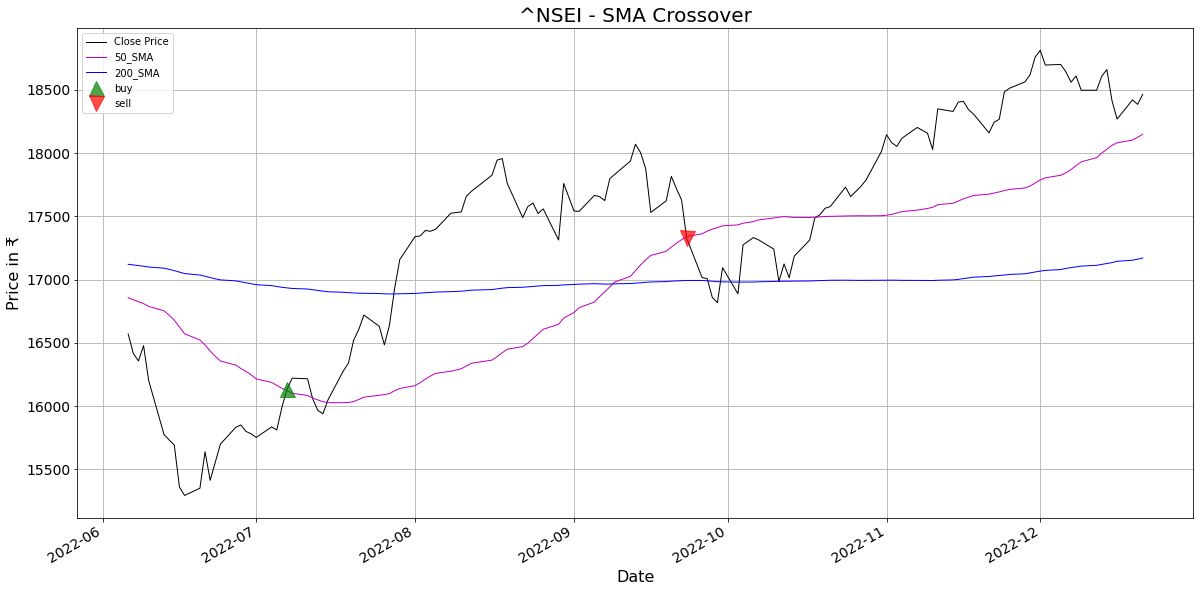

In [6]:
start_date = (datetime.date.today() + datetime.timedelta(days=-200)).strftime('%Y-%m-%d')
stock_id = '^NSEI'
plot_buy_sell(stock_id, start_date, True)

In [7]:
def get_buy_sell_signal(stock_symbol, start_date, end_date, moving_avg, short_window, mid_window,long_window):

    stock_df = web.DataReader(stock_symbol,  start_date, end_date)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()
        
        stock_df[mid_window_col] = stock_df['Close Price'].rolling(window = mid_window, min_periods = 1).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where(((stock_df[mid_window_col] < stock_df[long_window_col]) & (stock_df[mid_window_col] < stock_df['Close Price']) & (stock_df[long_window_col] > stock_df['Close Price']))
                                                                    , 1.0, stock_df['Signal']) 
    
    stock_df['Signal'] = np.where(((stock_df[mid_window_col] > stock_df[long_window_col])) & ((stock_df[mid_window_col] > stock_df['Close Price']) & (stock_df[long_window_col] < stock_df['Close Price']))
                                                                    , -1.0, stock_df['Signal']) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()
    
    df_pos = stock_df[(stock_df['Position'] >= 1) | (stock_df['Position'] <= -1)]
    df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)
    df_pos.drop(short_window_col, axis=1, inplace=True)
        
    df_pos['Stock'] = stock_symbol
    return df_pos.tail(1)

^NSEI
+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   50_SMA |   200_SMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2022-07-07 00:00:00 |       16132.9 |  16121.8 |   16934.2 |        1 | Buy        |
| 2022-09-23 00:00:00 |       17327.3 |  17340.7 |   16993.3 |       -1 | Sell       |
+---------------------+---------------+----------+-----------+----------+------------+


In [8]:
start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
moving_avg = 'SMA'
short_window = 20
mid_window = 50
long_window = 200

df_buy_sell = pd.DataFrame()

for stock_id in stock_ids:
    stock_id = stock_id.upper() + '.NS'
    tmp = get_buy_sell_signal(stock_id, start_date, end_date, moving_avg, short_window, mid_window, long_window)
    df_buy_sell = df_buy_sell.append(tmp)
    
df_buy_sell.sort_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-03-16,598.250000,596.660004,614.322503,1.0,Buy,WIPRO.NS
2022-03-22,1538.199951,1505.224001,1554.511114,1.0,Buy,TECHM.NS
2022-03-28,872.099976,869.891997,876.498505,1.0,Buy,MCDOWELL-N.NS
2022-03-28,99.849998,99.765000,102.152239,1.0,Buy,SAIL.NS
2022-03-30,6310.350098,6145.778975,6440.580425,1.0,Buy,LTIM.NS
...,...,...,...,...,...,...
2022-11-18,718.099976,724.865001,710.184001,-1.0,Sell,IRCTC.NS
2022-11-18,1102.400024,1109.878005,1010.186000,-1.0,Sell,CIPLA.NS
2022-11-22,1818.949951,1808.089001,1847.164755,1.0,Buy,INDIGO.NS


In [9]:
df_buy_sell[df_buy_sell['Position'] == 'Buy'].sort_index().tail(20)

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-03-28,872.099976,869.891997,876.498505,1.0,Buy,MCDOWELL-N.NS
2022-03-30,6310.350098,6145.778975,6440.580425,1.0,Buy,LTIM.NS
2022-04-01,895.950012,887.973007,900.266908,1.0,Buy,MOTILALOFS.NS
2022-04-01,711.599976,704.648002,723.480989,1.0,Buy,BERGEPAINT.NS
2022-04-04,571.799988,565.465997,592.318054,1.0,Buy,HDFCLIFE.NS
2022-04-04,4685.149902,4600.300986,4872.884013,1.0,Buy,NAUKRI.NS
2022-04-08,1374.949951,1372.989004,1413.057240,1.0,Buy,MUTHOOTFIN.NS
2022-04-11,3696.399902,3688.504980,3728.420762,1.0,Buy,TCS.NS
2022-04-27,10.300000,10.063000,10.333908,1.0,Buy,SUZLON.NS


In [10]:
df_buy_sell[df_buy_sell['Position'] == 'Sell'].sort_index().tail(30)

,Close Price,50_SMA,200_SMA,Signal,Position,Stock
Date,,,,,,
2022-09-16,556.349976,558.574997,531.937566,-1.0,Sell,ICICIPRULI.NS
2022-09-23,1446.150024,1454.463005,1432.762108,-1.0,Sell,HDFCBANK.NS
2022-09-23,890.450012,891.952001,831.881051,-1.0,Sell,GODREJCP.NS
2022-09-23,229.100006,233.311001,221.310000,-1.0,Sell,CANBK.NS
2022-09-23,1862.699951,1864.464998,1815.512630,-1.0,Sell,KOTAKBANK.NS
2022-09-26,1259.800049,1265.784998,1164.590573,-1.0,Sell,SBILIFE.NS
2022-09-26,742.599976,748.213997,723.441621,-1.0,Sell,AXISBANK.NS
2022-09-26,8834.950195,8894.745996,8154.814154,-1.0,Sell,MARUTI.NS
2022-09-26,1236.400024,1250.051006,989.071727,-1.0,Sell,M&M.NS


[*********************100%***********************]  1 of 1 completed


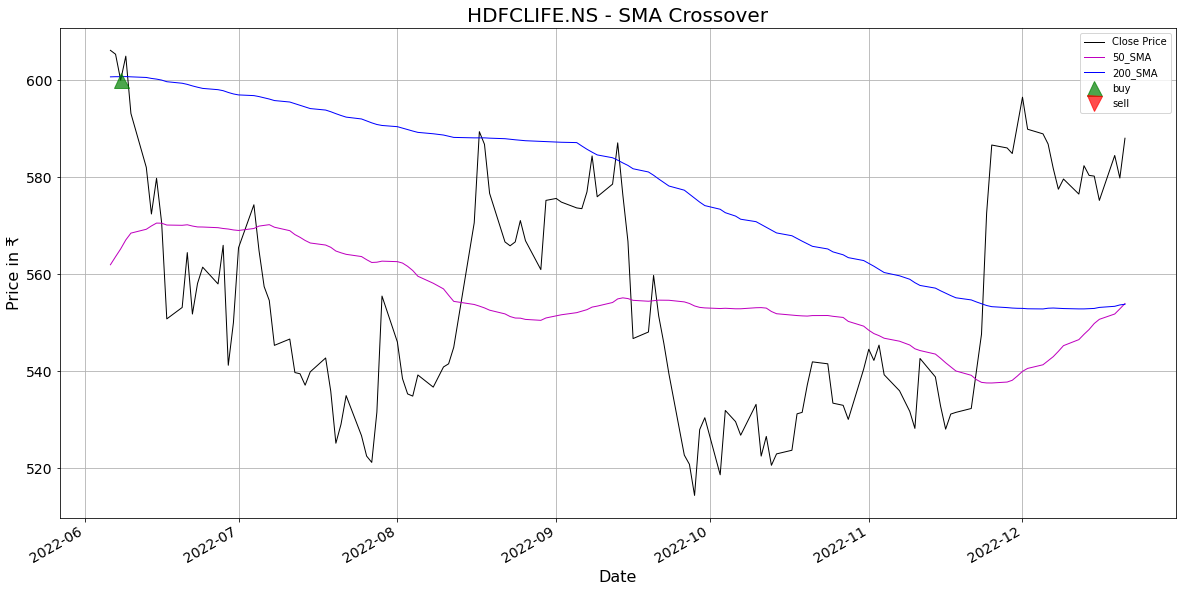

HDFCLIFE.NS
+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   50_SMA |   200_SMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2022-06-08 00:00:00 |        599.95 |  565.213 |   600.666 |        1 | Buy        |
+---------------------+---------------+----------+-----------+----------+------------+


In [11]:
start_date = (datetime.date.today() + datetime.timedelta(days=-200)).strftime('%Y-%m-%d')
stock_id = 'HDFCLIFE.NS'
plot_buy_sell(stock_id, start_date, True)